In [ ]:
# Changing to internal classification (<> pIC50 = 7.4)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import accuracy_score
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
from sklearn.ensemble import VotingClassifier, VotingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, classification_report
import joblib
import warnings; warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r"Representative_kinases (1)\Representative_kinases\Rep_kinases_dataset.csv", sep= "	")
def clean_df(df):
    df = df[df["p_standard_type"] == "pIC50"]
    df["SMILES"] = df["NonstereoAromaticSMILES"]
    df["Value"] = df["p_value"]
    df["Class"] = 1
    df["Kinase"] = df["Kinase_name"]
    df["Group"] = df["Kinase_group"]    
    dfx = df[["SMILES", "Class", "Value", "Kinase", "Group"]]
    del df
    
    return dfx

def gen_fps(df, fingerprint_type="Morgan", resolution=1024):
    if "SMILES" not in df.columns:
        raise ValueError("DataFrame must contain a 'SMILES' column.")
    
    smiles = df["SMILES"].tolist()
    mols = [Chem.MolFromSmiles(s) for s in smiles if Chem.MolFromSmiles(s)]
    del smiles
    if fingerprint_type == 'Morgan':
        generator = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=resolution)
    elif fingerprint_type == 'AtomPair':
        generator = rdFingerprintGenerator.GetAtomPairGenerator(fpSize=resolution)
    else:
        raise ValueError(f"Unsupported fingerprint type: {fingerprint_type}")
    fingerprints = generator.GetFingerprints(mols)
    del mols

    return fingerprints
    del fingerprints

In [3]:
df_KDR = df[df["Kinase_name"] == "KDR"]
df_FLT1 = df[df["Kinase_name"] == "FLT1"]
df_p110a = df[df["Kinase_name"] == "p110a"]
df_JAK1 = df[df["Kinase_name"] == "JAK1"]
df_JAK2 = df[df["Kinase_name"] == "JAK2"]
df_ErbB2 = df[df["Kinase_name"] == "ErbB2"]
df_EGFR = df[df["Kinase_name"] == "EGFR"]
df_PIM1 = df[df["Kinase_name"] == "PIM1"]
df_ROCK1 = df[df["Kinase_name"] == "ROCK1"]
df_ABL1 = df[df["Kinase_name"] == "ABL1"]

df_TK = df[df["Kinase_group"] == "TK"]
df_CMGC = df[df["Kinase_group"] == "CMGC"]
df_AGC = df[df["Kinase_group"] == "AGC"]
df_CAMK = df[df["Kinase_group"] == "CAMK"]
df_Atypical = df[df["Kinase_group"] == "Atypical"]

In [4]:
kinase_dfs = [
    df_KDR,
    df_FLT1,
    df_p110a,
    df_JAK1,
    df_JAK2,
    df_ErbB2,
    df_EGFR,
    df_PIM1,
    df_ROCK1,
    df_ABL1,
    df_TK,
    df_CMGC,
    df_AGC,
    df_CAMK,
    df_Atypical
]
cleaned_kinase_dfs = [clean_df(i) for i in kinase_dfs]
del kinase_dfs

cleaned_kinase_dfs1 = []
z = 1
for i in cleaned_kinase_dfs:
    i["Fingerprint"] = gen_fps(i, "Morgan", 2048)
    cleaned_kinase_dfs1.append(i)
    print("Iteration ",z," Complete") # for my sanity, waste of computation
    z+=1
del cleaned_kinase_dfs

Iteration  1  Complete
Iteration  2  Complete
Iteration  3  Complete
Iteration  4  Complete
Iteration  5  Complete
Iteration  6  Complete
Iteration  7  Complete
Iteration  8  Complete
Iteration  9  Complete
Iteration  10  Complete
Iteration  11  Complete
Iteration  12  Complete
Iteration  13  Complete
Iteration  14  Complete
Iteration  15  Complete


In [5]:
print(cleaned_kinase_dfs1[0].head())
for i in cleaned_kinase_dfs1:
    i['Class'] = (i['Value'] > 7.4).astype(int)
print(cleaned_kinase_dfs1[0].head())
for i in cleaned_kinase_dfs1:
    print(i["Kinase"].iloc[0])
df_KDR = cleaned_kinase_dfs1[0]
df_FLT1 = cleaned_kinase_dfs1[1]
df_p110a = cleaned_kinase_dfs1[2]
df_JAK1 = cleaned_kinase_dfs1[3]
df_JAK2 = cleaned_kinase_dfs1[4]
df_ErbB2 = cleaned_kinase_dfs1[5]
df_EGFR = cleaned_kinase_dfs1[6]
df_PIM1 = cleaned_kinase_dfs1[7]
df_ROCK1 = cleaned_kinase_dfs1[8]
df_ABL1 = cleaned_kinase_dfs1[9]

df_TK = cleaned_kinase_dfs1[10]
df_CMGC = cleaned_kinase_dfs1[11]
df_AGC = cleaned_kinase_dfs1[12]
df_CAMK = cleaned_kinase_dfs1[13]
df_Atypical = cleaned_kinase_dfs1[14]

                                                SMILES  Class  Value Kinase  \
176  NCC1OC(OC2C(CO)OC(OC3C(O)C(N)CC(N)C3OC3OC(CN)C...      1   7.74    KDR   
394  C=CC(=O)NCCOc1cc2ncnc(Nc3ccc(Br)cc3F)c2cc1NC(=...      1   6.60    KDR   
440  C=CC(=O)Nc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1=NCCO1      1   6.32    KDR   
444  C=CC(=O)Nc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN...      1   6.60    KDR   
448  C=CC(=O)Nc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN...      1   6.69    KDR   

    Group                                        Fingerprint  
176    TK  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
394    TK  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...  
440    TK  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
444    TK  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
448    TK  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
                                                SMILES  Class  Value Kinase  \
176  NCC1OC(OC2C(CO)OC(OC3C(O)C(N)CC(N)C3OC3OC(CN)C...      1   7.74

In [6]:
# Altered splits for 
def splits(df):
    y = df[["Class", "Value"]]
    X = df["Fingerprint"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)
    y_train_class = y_train["Class"]
    y_test_class = y_test["Class"]
    y_train_reg = y_train["Value"]
    y_test_reg = y_test["Value"]
    return X_train, X_test, y_train_class, y_test_class, y_train_reg, y_test_reg


In [7]:
# Kinases
X_train_KDR, X_test_KDR, y_train_class_KDR, y_test_class_KDR, y_train_reg_KDR, y_test_reg_KDR = splits(df_KDR)
X_train_FLT1, X_test_FLT1, y_train_class_FLT1, y_test_class_FLT1, y_train_reg_FLT1, y_test_reg_FLT1 = splits(df_FLT1)
X_train_p110a, X_test_p110a, y_train_class_p110a, y_test_class_p110a, y_train_reg_p110a, y_test_reg_p110a = splits(df_p110a)
X_train_JAK1, X_test_JAK1, y_train_class_JAK1, y_test_class_JAK1, y_train_reg_JAK1, y_test_reg_JAK1 = splits(df_JAK1)
X_train_JAK2, X_test_JAK2, y_train_class_JAK2, y_test_class_JAK2, y_train_reg_JAK2, y_test_reg_JAK2 = splits(df_JAK2)
X_train_ErbB2, X_test_ErbB2, y_train_class_ErbB2, y_test_class_ErbB2, y_train_reg_ErbB2, y_test_reg_ErbB2 = splits(df_ErbB2)
X_train_EGFR, X_test_EGFR, y_train_class_EGFR, y_test_class_EGFR, y_train_reg_EGFR, y_test_reg_EGFR = splits(df_EGFR)
X_train_PIM1, X_test_PIM1, y_train_class_PIM1, y_test_class_PIM1, y_train_reg_PIM1, y_test_reg_PIM1 = splits(df_PIM1)
X_train_ROCK1, X_test_ROCK1, y_train_class_ROCK1, y_test_class_ROCK1, y_train_reg_ROCK1, y_test_reg_ROCK1 = splits(df_ROCK1)
X_train_ABL1, X_test_ABL1, y_train_class_ABL1, y_test_class_ABL1, y_train_reg_ABL1, y_test_reg_ABL1 = splits(df_ABL1)
# Kinase Groups
X_train_TK, X_test_TK, y_train_class_TK, y_test_class_TK, y_train_reg_TK, y_test_reg_TK = splits(df_TK)
X_train_CMGC, X_test_CMGC, y_train_class_CMGC, y_test_class_CMGC, y_train_reg_CMGC, y_test_reg_CMGC = splits(df_CMGC)
X_train_AGC, X_test_AGC, y_train_class_AGC, y_test_class_AGC, y_train_reg_AGC, y_test_reg_AGC = splits(df_AGC)
X_train_CAMK, X_test_CAMK, y_train_class_CAMK, y_test_class_CAMK, y_train_reg_CAMK, y_test_reg_CAMK = splits(df_CAMK)
X_train_Atypical, X_test_Atypical, y_train_class_Atypical, y_test_class_Atypical, y_train_reg_Atypical, y_test_reg_Atypical = splits(df_Atypical)

In [8]:
print(X_train_ABL1.shape, y_train_class_ABL1.shape, y_train_reg_ABL1.shape)
# Confirming sample has same lengths for training
print(X_test_ABL1.shape, y_test_class_ABL1.shape, y_test_reg_ABL1.shape)


(835,) (835,) (835,)
(209,) (209,) (209,)


In [30]:
ensemble = VotingClassifier(estimators=[
    ('LR', LogisticRegression(max_iter=1000, solver='saga')),
    ('RF', RandomForestClassifier(random_state= 42, n_jobs= -1)), 
    ('LGB', LGBMClassifier(random_state= 42, n_jobs= -1)),
    ('CB', CatBoostClassifier(random_seed= 42, verbose= False))
], voting='soft')
ensemble.fit(np.stack(X_train_ABL1), y_train_class_ABL1)

[LightGBM] [Info] Number of positive: 547, number of negative: 288
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1716
[LightGBM] [Info] Number of data points in the train set: 835, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655090 -> initscore=0.641488
[LightGBM] [Info] Start training from score 0.641488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,estimators,"[('LR', ...), ('RF', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True


In [31]:
accuracy = ensemble.score(np.stack(X_test_ABL1), y_test_class_ABL1)
y_pred_class_ABL1 = ensemble.predict(np.stack(X_test_ABL1))
f1 = f1_score(y_test_class_ABL1, y_pred_class_ABL1, average='macro')
y_proba_class_ABL1 = ensemble.predict_proba(np.stack(X_test_ABL1))[:,1]
roc_auc = roc_auc_score(y_test_class_ABL1, y_proba_class_ABL1)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score (macro): {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_class_ABL1, y_pred_class_ABL1))
print(f"ROC AUC: {roc_auc:.4f}")


Accuracy: 0.8565
F1 Score (macro): 0.8352

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.71      0.78        73
           1       0.86      0.93      0.89       136

    accuracy                           0.86       209
   macro avg       0.86      0.82      0.84       209
weighted avg       0.86      0.86      0.85       209

ROC AUC: 0.9183


In [9]:
# functionalised:
def ensemble_model_class(X_train, y_train):
    ensemble = VotingClassifier(estimators=[
    ('LR', LogisticRegression(max_iter=1000, solver='saga')),
    ('RF', RandomForestClassifier(random_state= 42, n_jobs= -1)), 
    ('LGB', LGBMClassifier(random_state= 42, n_jobs= -1)),
    ('CB', CatBoostClassifier(random_seed= 42, verbose= False))
    ], voting='soft')
    ensemble.fit(np.stack(X_train), y_train)
    return ensemble

def output_metrics_class(ensemble, X_test, y_test):  
    accuracy = ensemble.score(np.stack(X_test), y_test)
    y_pred = ensemble.predict(np.stack(X_test))
    f1 = f1_score(y_test, y_pred, average='macro')
    y_proba = ensemble.predict_proba(np.stack(X_test))[:,1]
    roc_auc = roc_auc_score(y_test, y_proba)
    return accuracy, f1, roc_auc, y_pred

In [ ]:
# test-case for ABL1
ensemble = ensemble_model_class(np.stack(X_train_ABL1), y_train_class_ABL1)
output_metrics_class(ensemble, X_test_ABL1, y_test_class_ABL1)

In [58]:
# running the entire thing
def run_classification(X_train, X_test, y_train, y_test):
    model = ensemble_model_class(X_train, y_train)
    accuracy, f1, roc_auc, y_pred = output_metrics_class(model, X_test, y_test)
    outputs = [model, accuracy, f1, roc_auc, y_pred]
    return outputs

In [ ]:
outputs_KDR = run_classification(X_train_KDR, X_test_KDR, y_train_class_KDR, y_test_class_KDR)
ensemble_KDR, accuracy_KDR, f1_KDR, roc_auc_KDR, y_pred_class_KDR = outputs_
print(f"Accuracy: {accuracy_KDR:.4f}")
print(f"F1 Score (macro): {f1_KDR:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_class_KDR, y_pred_class_KDR))
print(f"ROC AUC: {roc_auc_KDR:.4f}")
joblib.dump(ensemble_KDR, "KDR_class.pkl")
print(f"Model Dumped to .pkl File \n({i})")

In [59]:
outputs_KDR = run_classification(X_train_KDR, X_test_KDR, y_train_class_KDR, y_test_class_KDR)
outputs_FLT1 = run_classification(X_train_FLT1, X_test_FLT1, y_train_class_FLT1, y_test_class_FLT1)
outputs_p110a = run_classification(X_train_p110a, X_test_p110a, y_train_class_p110a, y_test_class_p110a)
outputs_JAK1 = run_classification(X_train_JAK1, X_test_JAK1, y_train_class_JAK1, y_test_class_JAK1)
outputs_JAK2 = run_classification(X_train_JAK2, X_test_JAK2, y_train_class_JAK2, y_test_class_JAK2)
outputs_ErbB2 = run_classification(X_train_ErbB2, X_test_ErbB2, y_train_class_ErbB2, y_test_class_ErbB2)
outputs_EGFR = run_classification(X_train_EGFR, X_test_EGFR, y_train_class_EGFR, y_test_class_EGFR)
outputs_PIM1 = run_classification(X_train_PIM1, X_test_PIM1, y_train_class_PIM1, y_test_class_PIM1)
outputs_ROCK1 = run_classification(X_train_ROCK1, X_test_ROCK1, y_train_class_ROCK1, y_test_class_ROCK1)
outputs_ABL1 = run_classification(X_train_ABL1, X_test_ABL1, y_train_class_ABL1, y_test_class_ABL1)

outputs_TK = run_classification(X_train_TK, X_test_TK, y_train_class_TK, y_test_class_TK)
outputs_CMGC = run_classification(X_train_CMGC, X_test_CMGC, y_train_class_CMGC, y_test_class_CMGC)
outputs_AGC = run_classification(X_train_AGC, X_test_AGC, y_train_class_AGC, y_test_class_AGC)
outputs_CAMK = run_classification(X_train_CAMK, X_test_CAMK, y_train_class_CAMK, y_test_class_CAMK)
outputs_Atypical = run_classification(X_train_Atypical, X_test_Atypical, y_train_class_Atypical, y_test_class_Atypical)

[LightGBM] [Info] Number of positive: 1777, number of negative: 2537
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3910
[LightGBM] [Info] Number of data points in the train set: 4314, number of used features: 1955
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.411915 -> initscore=-0.356056
[LightGBM] [Info] Start training from score -0.356056
[LightGBM] [Info] Number of positive: 1559, number of negative: 1922
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3732
[LightGBM] [Info] Number of data points in the train set: 3481, number of used features: 1866
[LightGBM] [Info] [b

In [61]:
# Save all models as .pkl files
outputs = {
    "KDR": outputs_KDR,
    "FLT1": outputs_FLT1,
    "p110a": outputs_p110a,
    "JAK1": outputs_JAK1,
    "JAK2": outputs_JAK2,
    "ErbB2": outputs_ErbB2,
    "EGFR": outputs_EGFR,
    "PIM1": outputs_PIM1,
    "ROCK1": outputs_ROCK1,
    "ABL1": outputs_ABL1,
    "TK": outputs_TK,
    "CMGC": outputs_CMGC,
    "AGC": outputs_AGC,
    "CAMK": outputs_CAMK,
    "Atypical": outputs_Atypical,
}
"""
# To save models
for name, obj in outputs.items():
    joblib.dump(obj[0], f"{name}_class.pkl")
"""
# To print values (Acc, f1, rocauc)
for key, value_list in outputs.items():
    print(f"{key}: {value_list[1:-1]}")


KDR: [0.8100092678405931, 0.8019238535815252, 0.8897104851330202]
FLT1: [0.8059701492537313, 0.8047087792756398, 0.8818139322404837]
p110a: [0.8517397881996974, 0.8302890258215962, 0.9146475434848947]
JAK1: [0.875, 0.8274374460742019, 0.9291738437001594]
JAK2: [0.7781402936378466, 0.7749487096425871, 0.8705198855141185]
ErbB2: [0.7710487444608567, 0.7708487560298649, 0.8657203715343251]
EGFR: [0.7796352583586627, 0.7793166936131137, 0.8682645805013824]
PIM1: [0.8626943005181347, 0.8169257340241796, 0.9071043910521954]
ROCK1: [0.8312236286919831, 0.8035151716133311, 0.889693154996066]
ABL1: [0.8181818181818182, 0.7896270396270396, 0.8937937937937939]
TK: [0.7643484132343011, 0.7633952461061329, 0.8466669033724376]
CMGC: [0.7873117298037425, 0.7796326512993179, 0.8722032066294362]
AGC: [0.7857627118644068, 0.7824134415368584, 0.8698326826547687]
CAMK: [0.8164726947179947, 0.8009423259978528, 0.8908800868886401]
Atypical: [0.6653108657757117, 0.6618140730672868, 0.7927325865116632]


In [51]:
# Checking to make sure joblib dump / load is functional
ensemble = joblib.load('TK_class.pkl')
accuracy, f1, roc_auc, y_pred = output_metrics_class(ensemble, X_test_TK, y_test_class_TK)
print(accuracy, "\n", f1, "\n", roc_auc)
accuracy, f1, roc_auc, y_pred = output_metrics_class(outputs["TK"][0], X_test_TK, y_test_class_TK)
print(accuracy, "\n", f1, "\n", roc_auc)

0.7624352914697277 
 0.7612236163995643 
 0.847081803778949
0.7624352914697277 
 0.7612236163995643 
 0.847081803778949


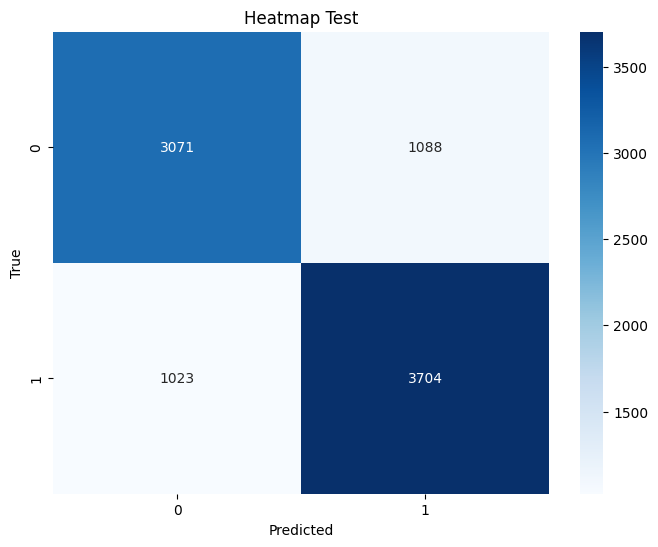

In [54]:
# Heatmap generation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def heatmap(_, title= ""):
    plt.figure(figsize=(8, 6))
    sns.heatmap(_, annot=True, fmt='d', cmap='Blues',)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()
_ = confusion_matrix(y_test_class_TK, outputs["TK"][-1])
heatmap(_, title= "Heatmap Test")

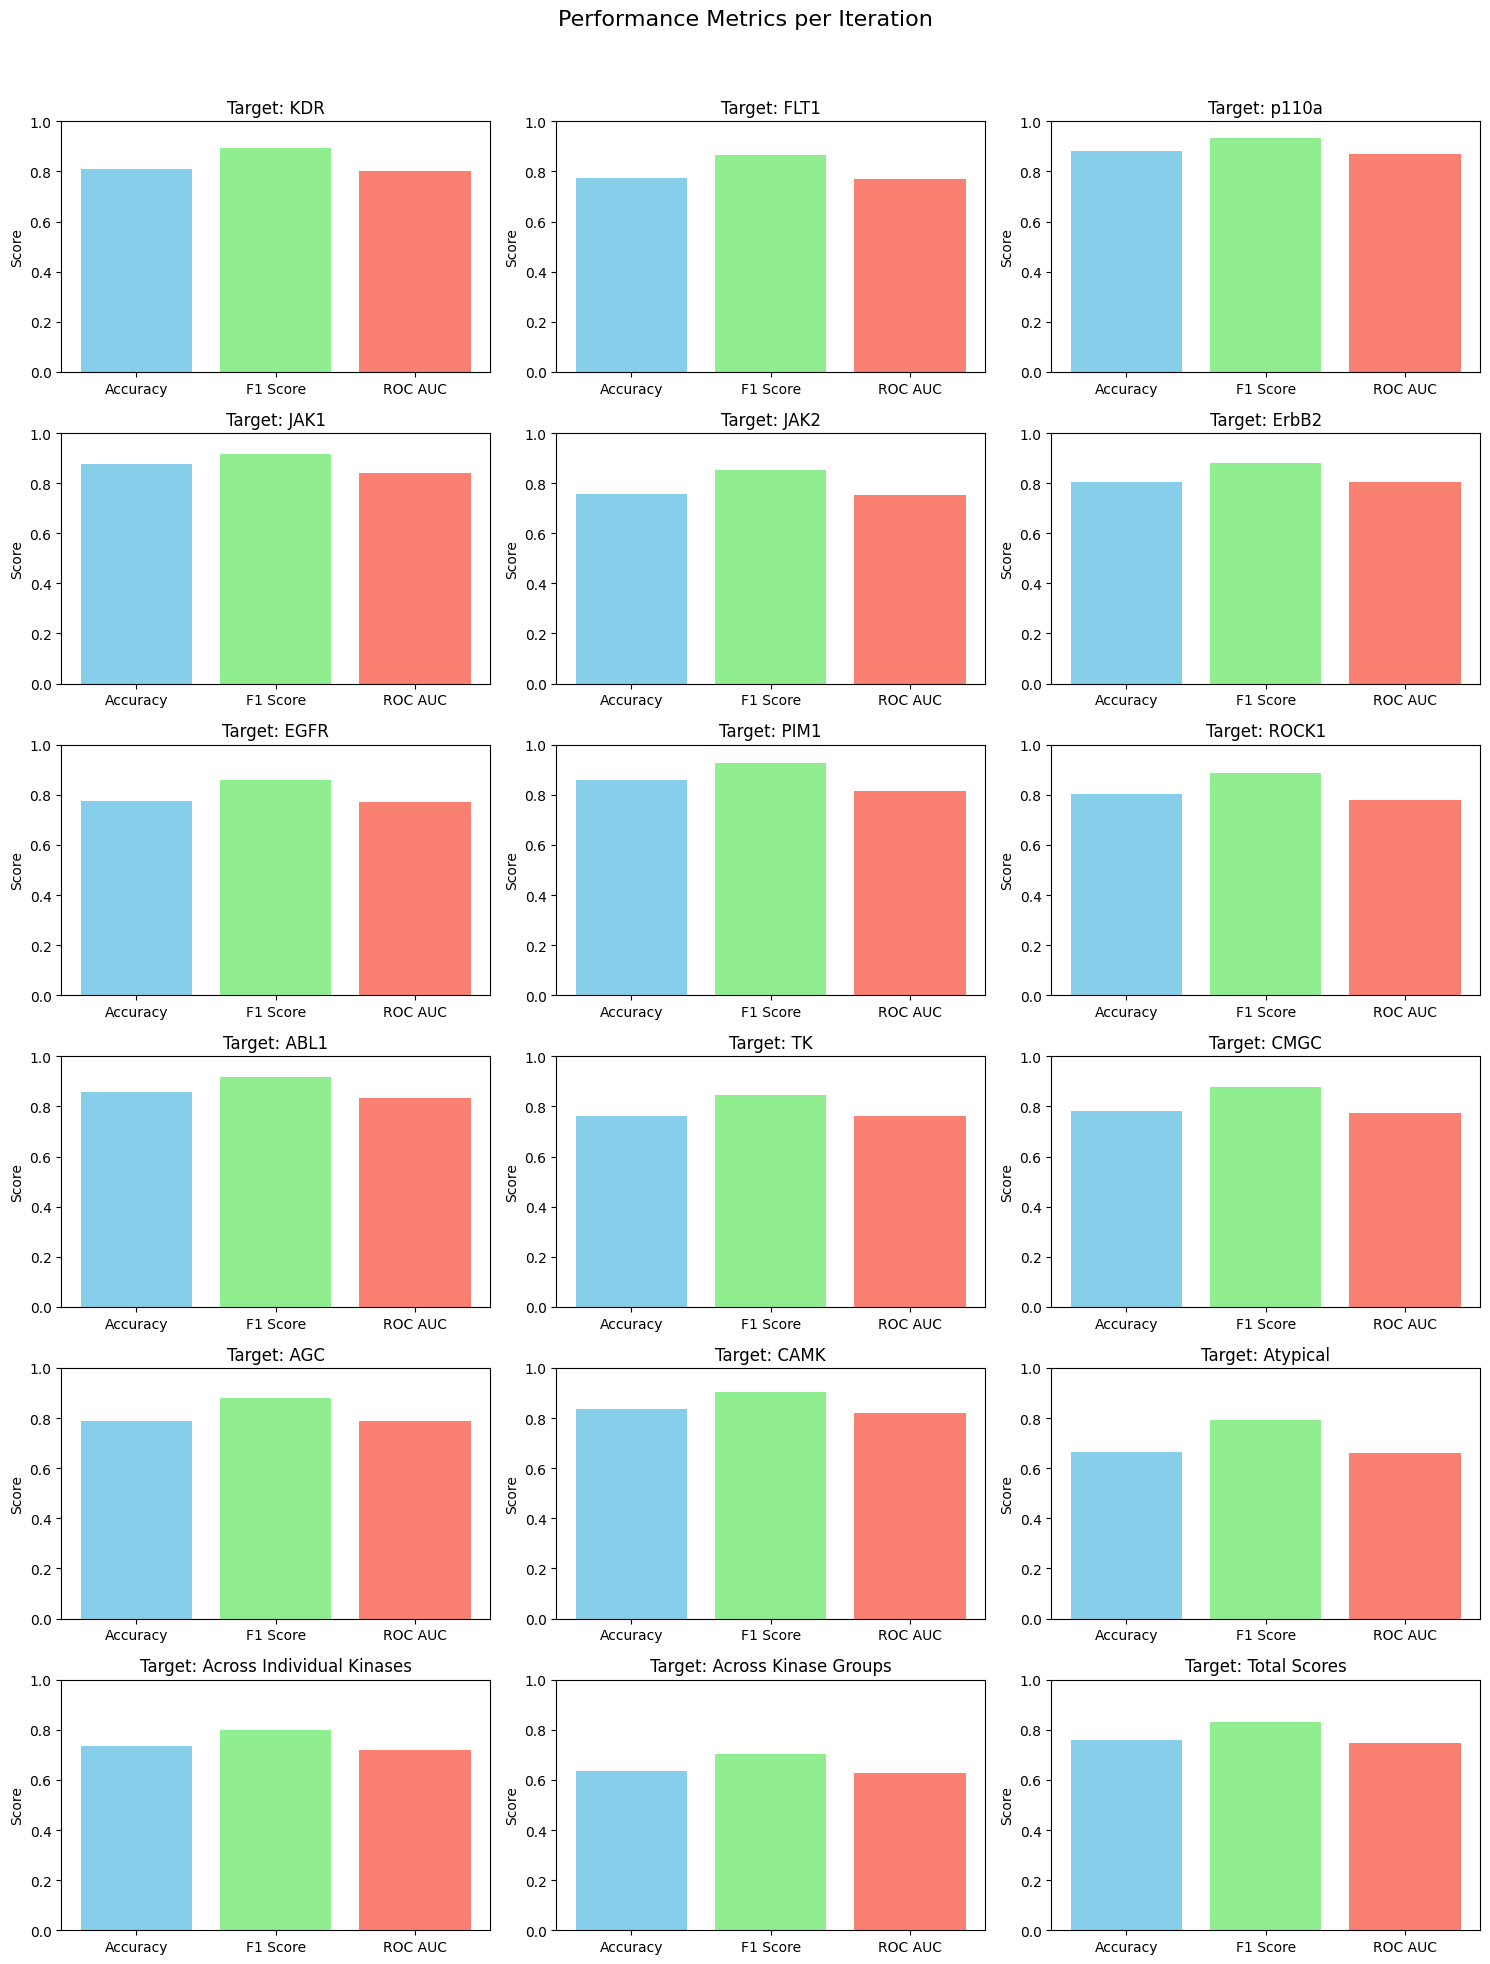

In [97]:
import matplotlib.pyplot as plt

accuracy_scores = [outputs[key][1] for key in outputs]
accuracy_scores.append(sum(accuracy_scores[0:9])/10)
accuracy_scores.append(sum(accuracy_scores[10:14])/5)
accuracy_scores.append(sum(accuracy_scores[0:14])/15)
f1_scores = [outputs[key][3] for key in outputs]
f1_scores.append(sum(f1_scores[0:9])/10)
f1_scores.append(sum(f1_scores[10:14])/5)
f1_scores.append(sum(f1_scores[0:14])/15)
roc_auc_scores = [outputs[key][2] for key in outputs]
roc_auc_scores.append(sum(roc_auc_scores[0:9])/10)
roc_auc_scores.append(sum(roc_auc_scores[10:14])/5)
roc_auc_scores.append(sum(roc_auc_scores[0:14])/15)

kinase_names = [
    "KDR",
    "FLT1",
    "p110a",
    "JAK1",
    "JAK2",
    "ErbB2",
    "EGFR",
    "PIM1",
    "ROCK1",
    "ABL1",
    "TK",
    "CMGC",
    "AGC",
    "CAMK",
    "Atypical",
    "Across Individual Kinases",
    "Across Kinase Groups",
    "Total Scores"
]
n = len(accuracy_scores)

fig, axes = plt.subplots(6, 3, figsize=(15, 20))
fig.suptitle('Performance Metrics per Iteration', fontsize=16)

axes = axes.flatten()

for i in range(n):
    ax = axes[i]
    metrics = ['Accuracy', 'F1 Score', 'ROC AUC']
    values = [accuracy_scores[i], f1_scores[i], roc_auc_scores[i]]
    
    # Bar chart
    ax.bar(metrics, values, color=['skyblue', 'lightgreen', 'salmon'])
    ax.set_ylim(0, 1)
    ax.set_title(f'Target: {kinase_names[i]}')
    ax.set_ylabel('Score')
    ax.set_xticks(range(len(metrics)))
    ax.set_xticklabels(metrics)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('comparison_of_scores_class.png')

In [91]:
print(f"Best Accuracy Metric: {max(accuracy_scores)}, {kinase_names[accuracy_scores.index(max(accuracy_scores))]}")
print(f"Best F1 Metric: {max(f1_scores)}, {kinase_names[f1_scores.index(max(f1_scores))]}")
print(f"Best ROC AUC Metric: {max(roc_auc_scores)}, {kinase_names[roc_auc_scores.index(max(roc_auc_scores))]}")

Best Accuracy Metric: 0.8835098335854765, p110a
Best F1 Metric: 0.9342386328959413, p110a
Best ROC AUC Metric: 0.8680895178115564, p110a


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def heatmap(_, title= ""):
    plt.figure(figsize=(8, 6))
    sns.heatmap(_, annot=True, fmt='d', cmap='Blues',)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()
_ = confusion_matrix(y_test_class_TK, outputs["TK"][-1])
heatmap(_, title= "Heatmap Test")

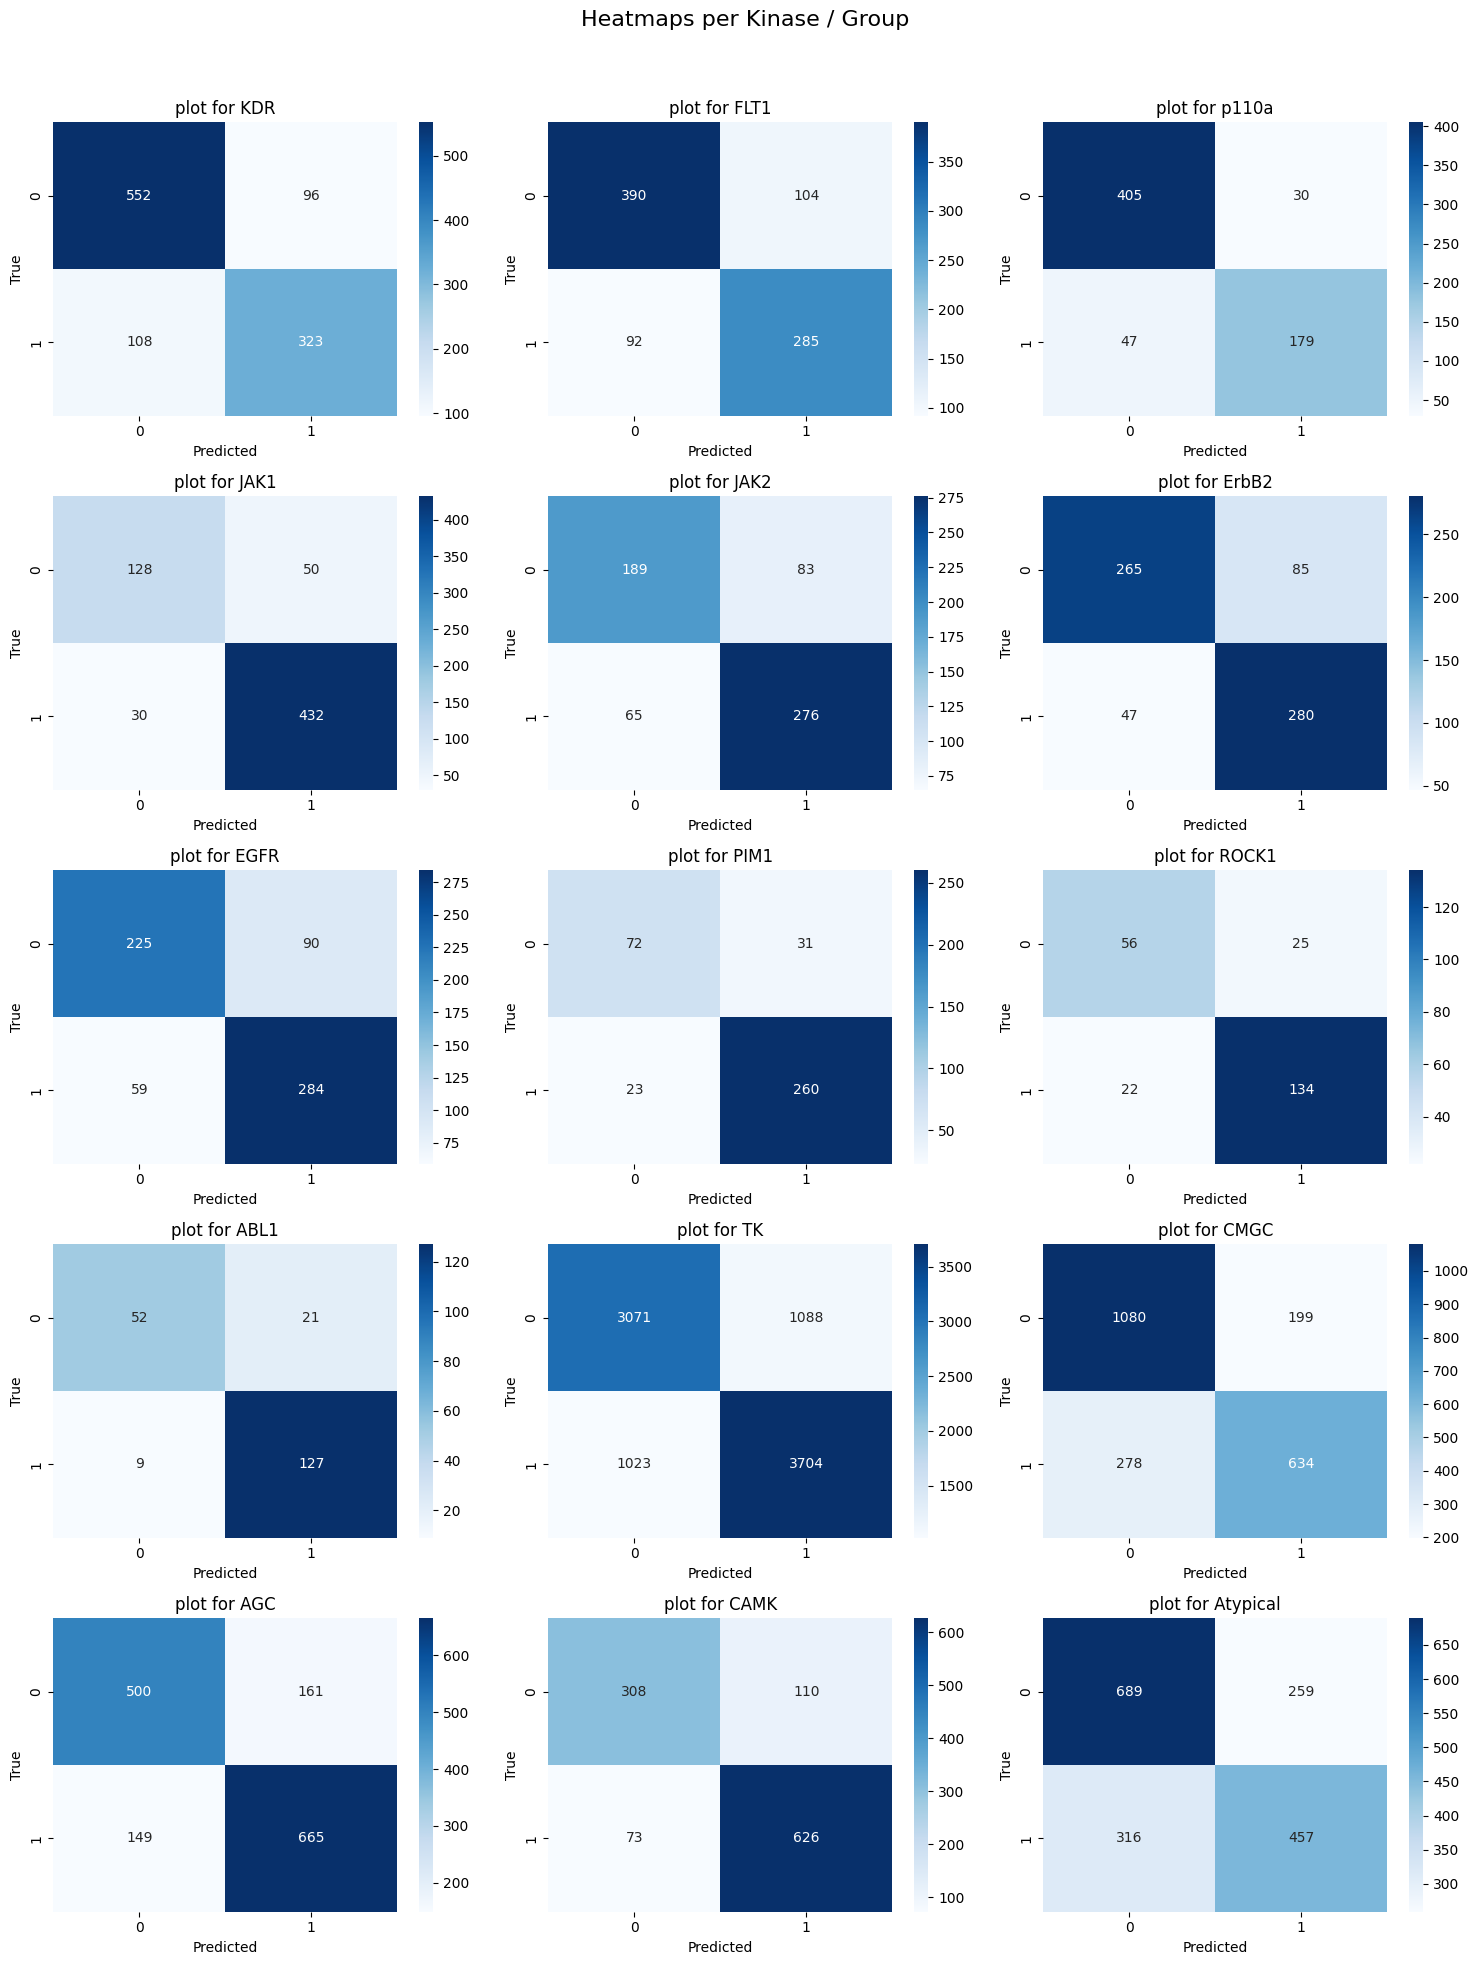

In [96]:
y_preds = [outputs[key][-1] for key in outputs]
kinase_names = [
    "KDR",
    "FLT1",
    "p110a",
    "JAK1",
    "JAK2",
    "ErbB2",
    "EGFR",
    "PIM1",
    "ROCK1",
    "ABL1",
    "TK",
    "CMGC",
    "AGC",
    "CAMK",
    "Atypical"
]
y_tests= [
    y_test_class_KDR,
    y_test_class_FLT1,
    y_test_class_p110a,
    y_test_class_JAK1,
    y_test_class_JAK2,
    y_test_class_ErbB2,
    y_test_class_EGFR,
    y_test_class_PIM1,
    y_test_class_ROCK1,
    y_test_class_ABL1,
    y_test_class_TK,
    y_test_class_CMGC,
    y_test_class_AGC,
    y_test_class_CAMK,
    y_test_class_Atypical,
]
fig, axes = plt.subplots(5, 3, figsize=(15, 20))
fig.suptitle('Heatmaps per Kinase / Group', fontsize=16)

axes = axes.flatten()
n = len(y_preds)
for i in range(n):
    
    _ = confusion_matrix(y_tests[i], y_preds[i])
    sns.heatmap(_, annot= True, fmt= "d", cmap= "Blues", ax= axes[i])
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")
    axes[i].set_title(f"plot for {kinase_names[i]}")
    

    
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('heatmaps_class.png')

In [14]:
from sklearn.linear_model import LinearRegression

def ensemble_model_reg(X_train, y_train):
    ensemble = VotingRegressor(estimators=[
    ('LR', LinearRegression()),
    ('RF', RandomForestRegressor(random_state= 42, n_jobs= -1)), 
    ('LGB', LGBMRegressor(random_state= 42, n_jobs= -1)),
    ('CB', CatBoostRegressor(random_seed= 42, verbose= False))
    ])
    ensemble.fit(np.stack(X_train), y_train)
    return ensemble

In [11]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def output_metrics_reg(ensemble, X_test, y_test, include_mape=True):
    X = np.stack(X_test)
    y = y_test

    y_pred = ensemble.predict(X)

    r2 = ensemble.score(X, y)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)

    mape_value = None
    if include_mape:
        eps = 1e-8
        denom = np.maximum(np.abs(y), eps)
        mape_value = np.mean(np.abs((y_pred - y) / denom)) * 100.0

    return r2, rmse, mae, mape_value, y_pred


In [15]:
def run_regression(X_train, X_test, y_train, y_test):
    model = ensemble_model_reg(X_train, y_train)
    r2, rmse, mae, mape, y_pred = output_metrics_reg(model, X_test, y_test)
    outputs = [model, r2, rmse, mae, mape, y_pred]
    return outputs
outputs_KDR = run_regression(X_train_KDR, X_test_KDR, y_train_reg_KDR, y_test_reg_KDR)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3910
[LightGBM] [Info] Number of data points in the train set: 4314, number of used features: 1955
[LightGBM] [Info] Start training from score 7.283938


In [16]:
print(outputs_KDR[1:])

[0.5362981022723903, np.float64(0.5471529396292341), 0.4125523435426854, np.float64(5.669189137623084), array([7.67224633, 7.44634116, 8.7557999 , ..., 6.86410317, 6.93154646,
       7.6486259 ], shape=(1079,))]


In [18]:
outputs_KDR = run_regression(X_train_KDR, X_test_KDR, y_train_reg_KDR, y_test_reg_KDR)
outputs_FLT1 = run_regression(X_train_FLT1, X_test_FLT1, y_train_reg_FLT1, y_test_reg_FLT1)
outputs_p110a = run_regression(X_train_p110a, X_test_p110a, y_train_reg_p110a, y_test_reg_p110a)
outputs_JAK1 = run_regression(X_train_JAK1, X_test_JAK1, y_train_reg_JAK1, y_test_reg_JAK1)
outputs_JAK2 = run_regression(X_train_JAK2, X_test_JAK2, y_train_reg_JAK2, y_test_reg_JAK2)
outputs_ErbB2 = run_regression(X_train_ErbB2, X_test_ErbB2, y_train_reg_ErbB2, y_test_reg_ErbB2)
outputs_EGFR = run_regression(X_train_EGFR, X_test_EGFR, y_train_reg_EGFR, y_test_reg_EGFR)
outputs_PIM1 = run_regression(X_train_PIM1, X_test_PIM1, y_train_reg_PIM1, y_test_reg_PIM1)
outputs_ROCK1 = run_regression(X_train_ROCK1, X_test_ROCK1, y_train_reg_ROCK1, y_test_reg_ROCK1)
outputs_ABL1 = run_regression(X_train_ABL1, X_test_ABL1, y_train_reg_ABL1, y_test_reg_ABL1)

outputs_TK = run_regression(X_train_TK, X_test_TK, y_train_reg_TK, y_test_reg_TK)
outputs_CMGC = run_regression(X_train_CMGC, X_test_CMGC, y_train_reg_CMGC, y_test_reg_CMGC)
outputs_AGC = run_regression(X_train_AGC, X_test_AGC, y_train_reg_AGC, y_test_reg_AGC)
outputs_CAMK = run_regression(X_train_CAMK, X_test_CAMK, y_train_reg_CAMK, y_test_reg_CAMK)
outputs_Atypical = run_regression(X_train_Atypical, X_test_Atypical, y_train_reg_Atypical, y_test_reg_Atypical)

outputs = {
    "KDR": outputs_KDR,
    "FLT1": outputs_FLT1,
    "p110a": outputs_p110a,
    "JAK1": outputs_JAK1,
    "JAK2": outputs_JAK2,
    "ErbB2": outputs_ErbB2,
    "EGFR": outputs_EGFR,
    "PIM1": outputs_PIM1,
    "ROCK1": outputs_ROCK1,
    "ABL1": outputs_ABL1,
    "TK": outputs_TK,
    "CMGC": outputs_CMGC,
    "AGC": outputs_AGC,
    "CAMK": outputs_CAMK,
    "Atypical": outputs_Atypical,
}

for name, obj in outputs.items():
    joblib.dump(obj[0], f"{name}_reg.pkl")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3910
[LightGBM] [Info] Number of data points in the train set: 4314, number of used features: 1955
[LightGBM] [Info] Start training from score 7.283938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3732
[LightGBM] [Info] Number of data points in the train set: 3481, number of used features: 1866
[LightGBM] [Info] Start training from score 7.333694
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

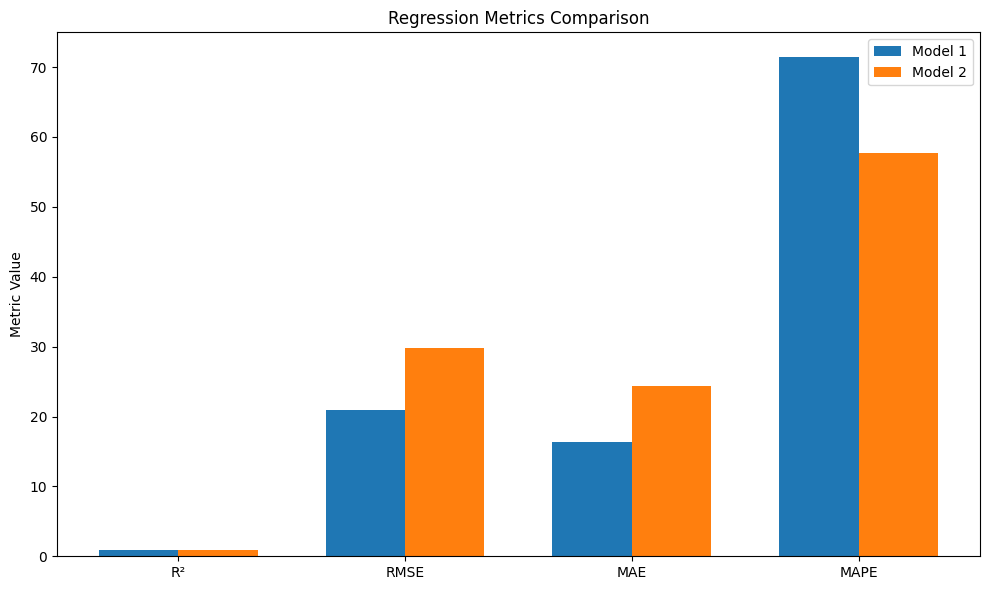

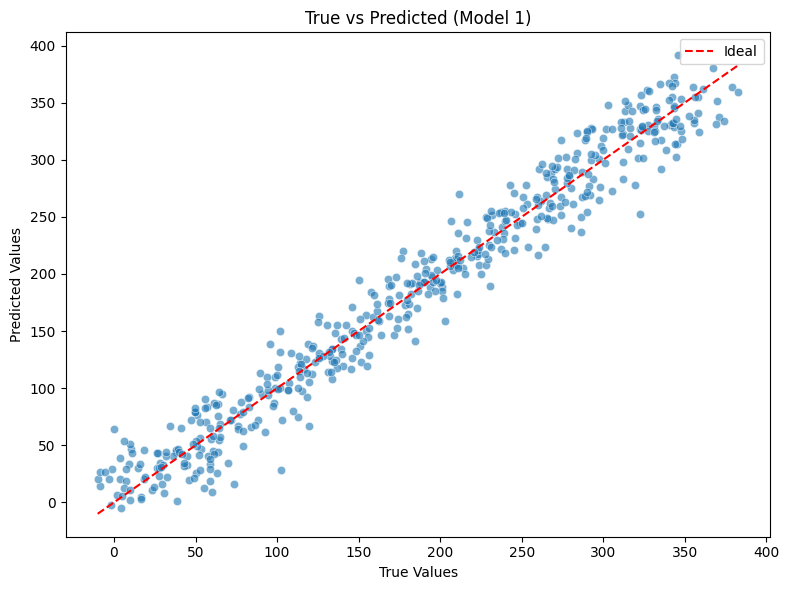

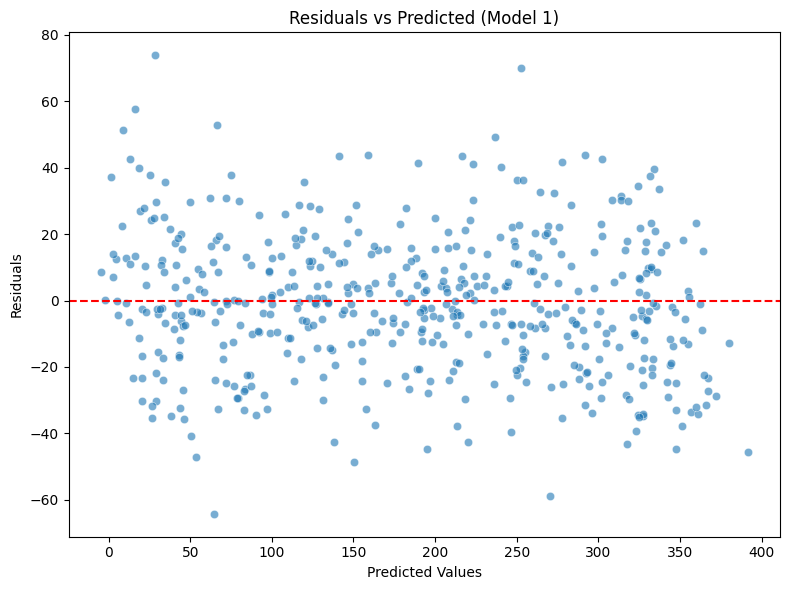

In [19]:
# Generated code for inspo
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Example: Synthetic data
np.random.seed(42)
X = np.random.rand(500, 1) * 100
true_coef = 3.5
true_intercept = 10
noise = np.random.randn(500) * 15
y_true = true_coef * X.flatten() + true_intercept + noise

# Simulate predictions from two models
y_pred_model1 = true_coef * X.flatten() + true_intercept + np.random.randn(500) * 15
y_pred_model2 = true_coef * X.flatten() + true_intercept + np.random.randn(500) * 25

# Compute metrics
def compute_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100
    return r2, rmse, mae, mape

metrics_model1 = compute_metrics(y_true, y_pred_model1)
metrics_model2 = compute_metrics(y_true, y_pred_model2)

# Prepare data for bar chart
models = ['Model 1', 'Model 2']
metric_names = ['R²', 'RMSE', 'MAE', 'MAPE']
values = np.array([metrics_model1, metrics_model2])

# --- 1. Bar chart for metrics comparison ---
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(metric_names))

plt.bar(x - bar_width/2, values[0], bar_width, label='Model 1')
plt.bar(x + bar_width/2, values[1], bar_width, label='Model 2')

plt.xticks(x, metric_names)
plt.ylabel('Metric Value')
plt.title('Regression Metrics Comparison')
plt.legend()
plt.tight_layout()
plt.show()

# --- 2. True vs Predicted Scatter Plot ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_true, y=y_pred_model1, alpha=0.6)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Ideal')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted (Model 1)')
plt.legend()
plt.tight_layout()
plt.show()

# --- 3. Residuals vs Predicted Plot ---
residuals = y_true - y_pred_model1
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_model1, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted (Model 1)')
plt.tight_layout()
plt.show()


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_regression_outputs(outputs, y_true):
    """
    Visualize regression metrics and predictions from a dictionary of outputs.
    
    Parameters
    ----------
    outputs : dict
        Keys are model names (e.g., 'KDR', 'FLT1'), values are lists:
        [model_name, r2, rmse, mae, mape, y_pred]
    y_true : array-like
        True target values for comparison.
    """
    # Extract metrics
    model_names = []
    r2_scores, rmse_scores, mae_scores, mape_scores = [], [], [], []

    for key, vals in outputs.items():
        model_names.append(key)
        r2_scores.append(vals[1])
        rmse_scores.append(vals[2])
        mae_scores.append(vals[3])
        mape_scores.append(vals[4])

    # --- 1. Bar chart for metrics comparison ---
    metrics = ['R²', 'RMSE', 'MAE', 'MAPE']
    values = [r2_scores, rmse_scores, mae_scores, mape_scores]

    plt.figure(figsize=(12, 6))
    x = np.arange(len(model_names))
    bar_width = 0.2

    for i, metric_vals in enumerate(values):
        plt.bar(x + i*bar_width, metric_vals, width=bar_width, label=metrics[i])

    plt.xticks(x + bar_width*1.5, model_names, rotation=45)
    plt.ylabel('Metric Value')
    plt.title('Regression Metrics Comparison Across Models')
    plt.legend()
    plt.tight_layout()
    plt.show()

"\n    # --- 2. True vs Predicted Scatter for each model ---\n    for key, vals in outputs.items():\n        y_pred = vals[5]\n        plt.figure(figsize=(8, 6))\n        sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)\n        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Ideal')\n        plt.xlabel('True Values')\n        plt.ylabel('Predicted Values')\n        plt.title(f'True vs Predicted ({key})')\n        plt.legend()\n        plt.tight_layout()\n        plt.show()\n\n    # --- 3. Residuals vs Predicted for each model ---\n    for key, vals in outputs.items():\n        y_pred = vals[5]\n        residuals = y_true - y_pred\n        plt.figure(figsize=(8, 6))\n        sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)\n        plt.axhline(0, color='red', linestyle='--')\n        plt.xlabel('Predicted Values')\n        plt.ylabel('Residuals')\n        plt.title(f'Residuals vs Predicted ({key})')\n        plt.tight_layout()\n        plt.show()\n"

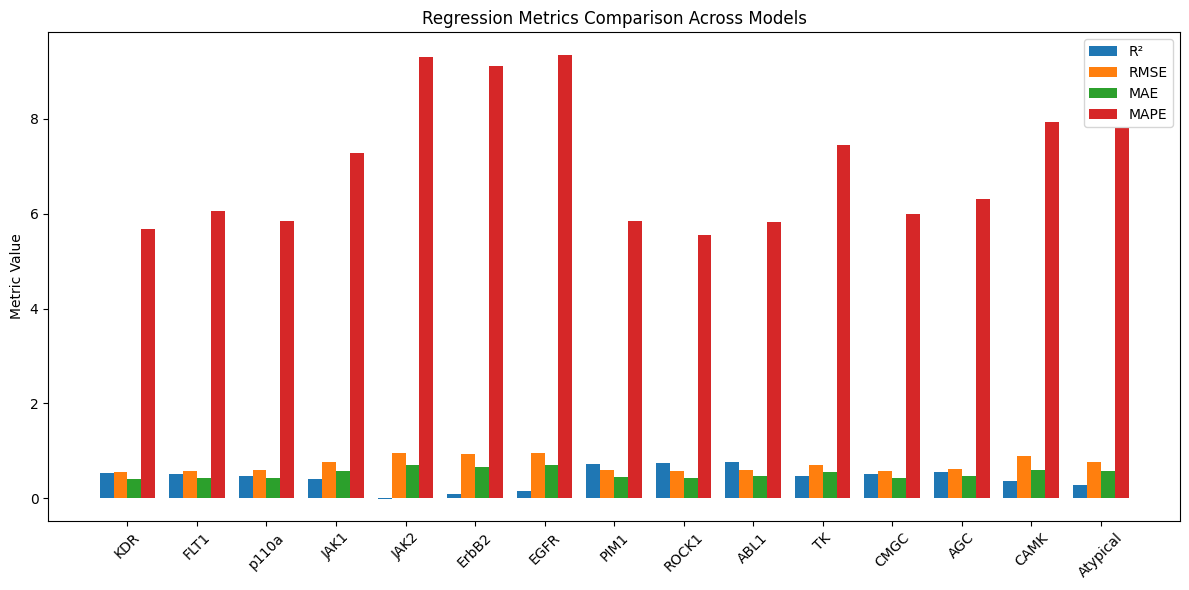

In [22]:
visualize_regression_outputs(outputs, "hello")
# Not sure if MAPE should be plotted with the rest of them

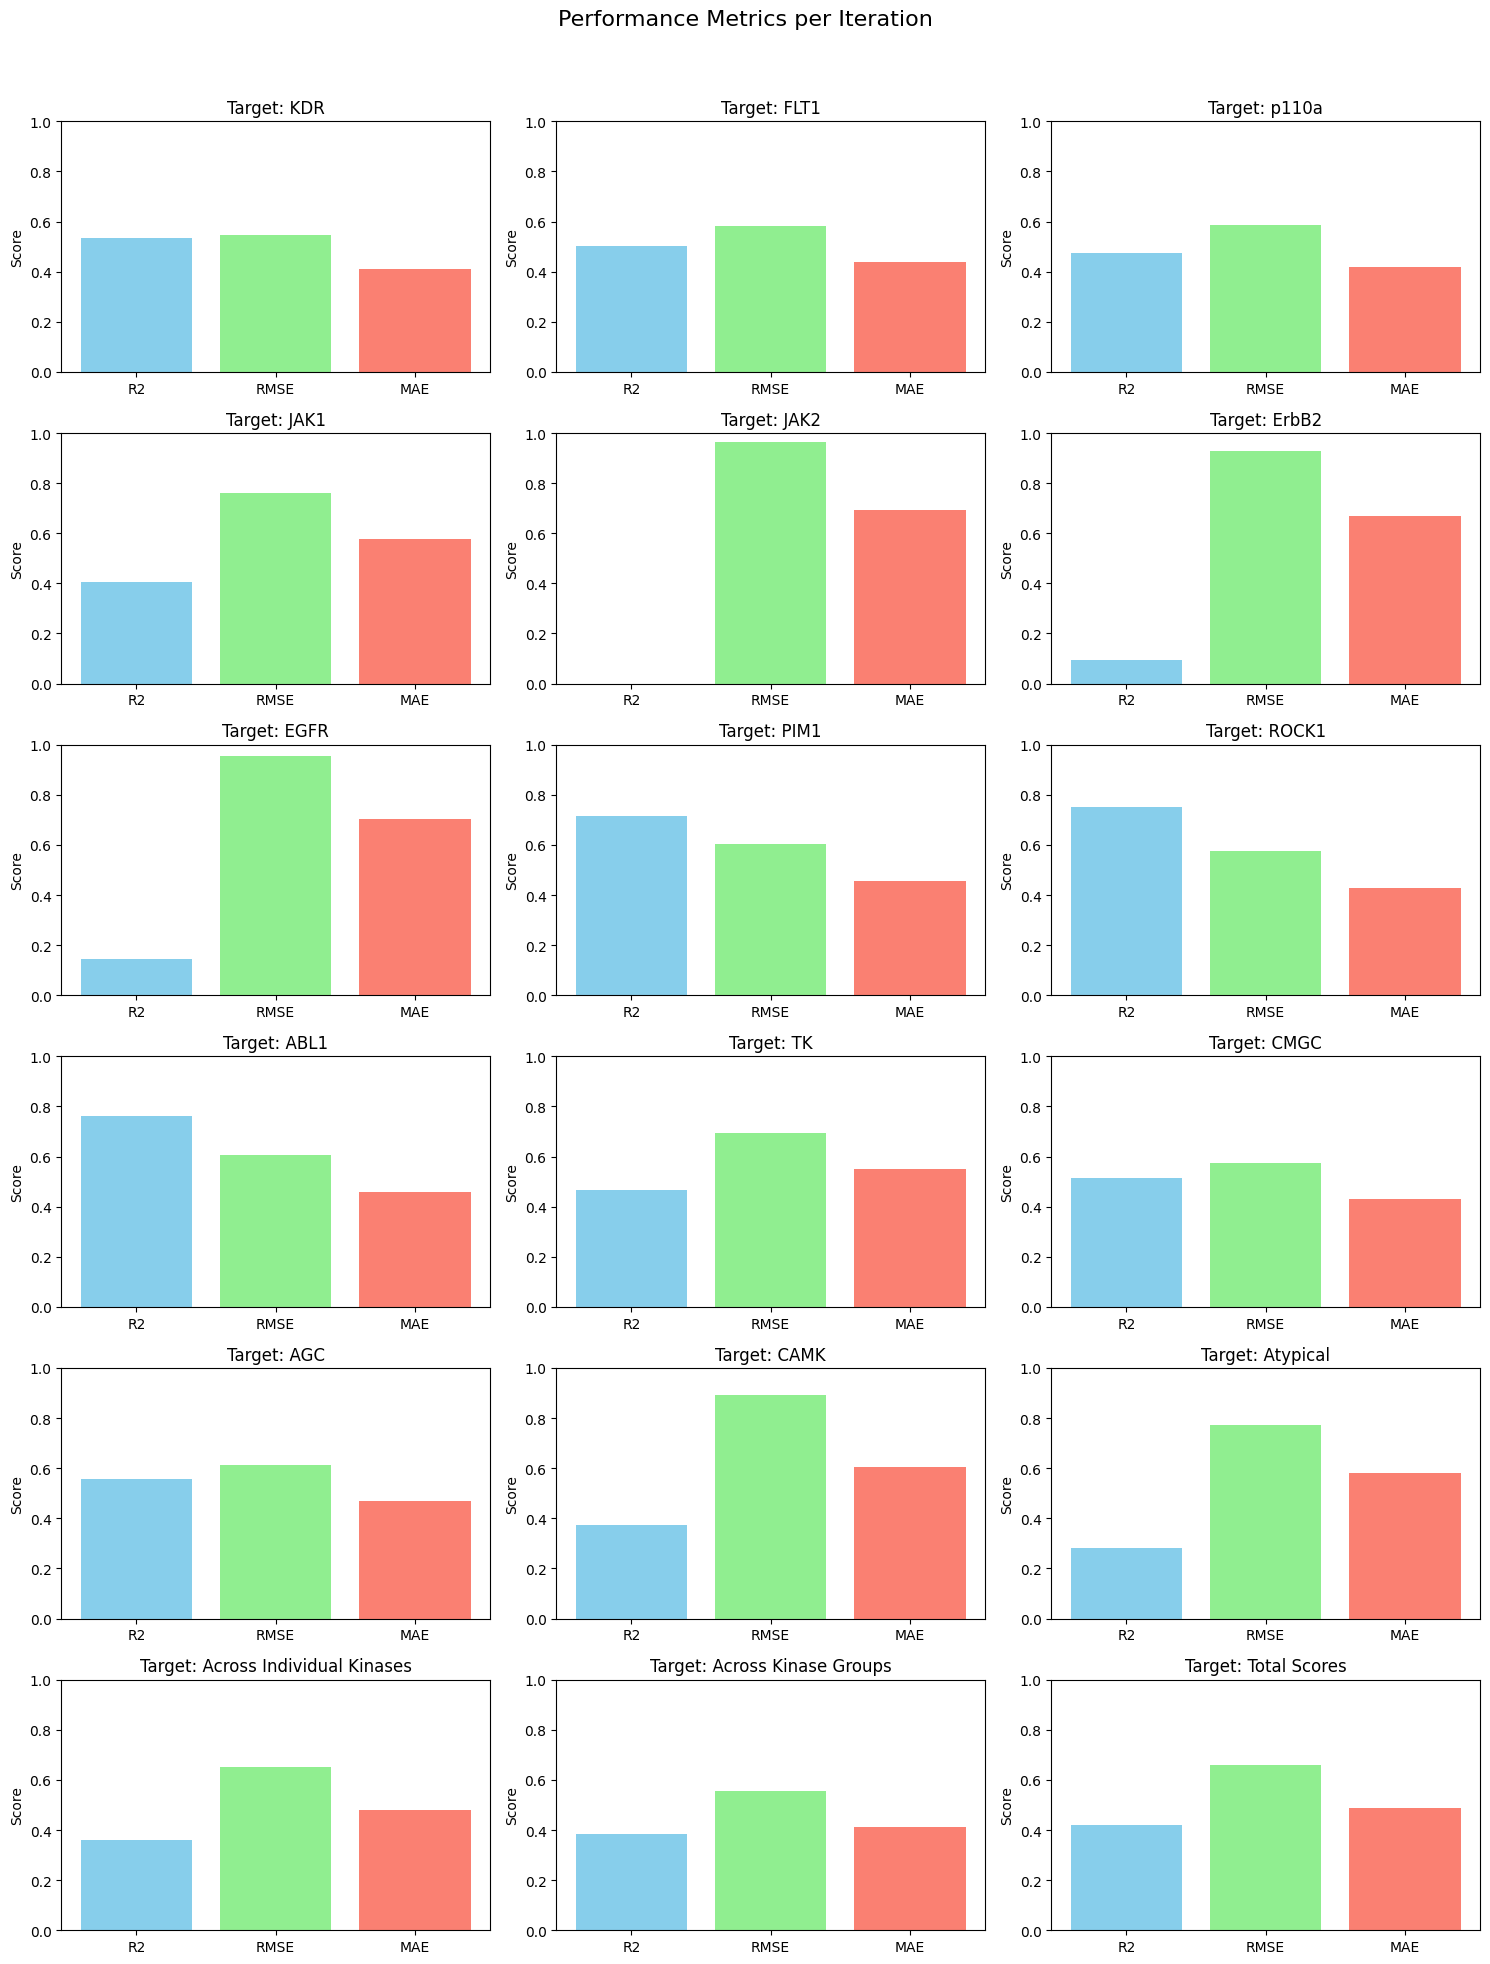

In [24]:
import matplotlib.pyplot as plt

R2_scores = [outputs[key][1] for key in outputs]
R2_scores.append(sum(R2_scores[0:9])/10)
R2_scores.append(sum(R2_scores[10:14])/5)
R2_scores.append(sum(R2_scores[0:14])/15)
rmse_scores = [outputs[key][2] for key in outputs]
rmse_scores.append(sum(rmse_scores[0:9])/10)
rmse_scores.append(sum(rmse_scores[10:14])/5)
rmse_scores.append(sum(rmse_scores[0:14])/15)
mae_scores = [outputs[key][3] for key in outputs]
mae_scores.append(sum(mae_scores[0:9])/10)
mae_scores.append(sum(mae_scores[10:14])/5)
mae_scores.append(sum(mae_scores[0:14])/15)

kinase_names = [
    "KDR",
    "FLT1",
    "p110a",
    "JAK1",
    "JAK2",
    "ErbB2",
    "EGFR",
    "PIM1",
    "ROCK1",
    "ABL1",
    "TK",
    "CMGC",
    "AGC",
    "CAMK",
    "Atypical",
    "Across Individual Kinases",
    "Across Kinase Groups",
    "Total Scores"
]
n = len(R2_scores)

fig, axes = plt.subplots(6, 3, figsize=(15, 20))
fig.suptitle('Performance Metrics per Iteration', fontsize=16)

axes = axes.flatten()

for i in range(n):
    ax = axes[i]
    metrics = ['R2', 'RMSE', 'MAE']
    values = [R2_scores[i], rmse_scores[i], mae_scores[i]]
    
    # Bar chart
    ax.bar(metrics, values, color=['skyblue', 'lightgreen', 'salmon'])
    ax.set_ylim(0, 1)
    ax.set_title(f'Target: {kinase_names[i]}')
    ax.set_ylabel('Score')
    ax.set_xticks(range(len(metrics)))
    ax.set_xticklabels(metrics)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('comparison_of_scores_reg.png')

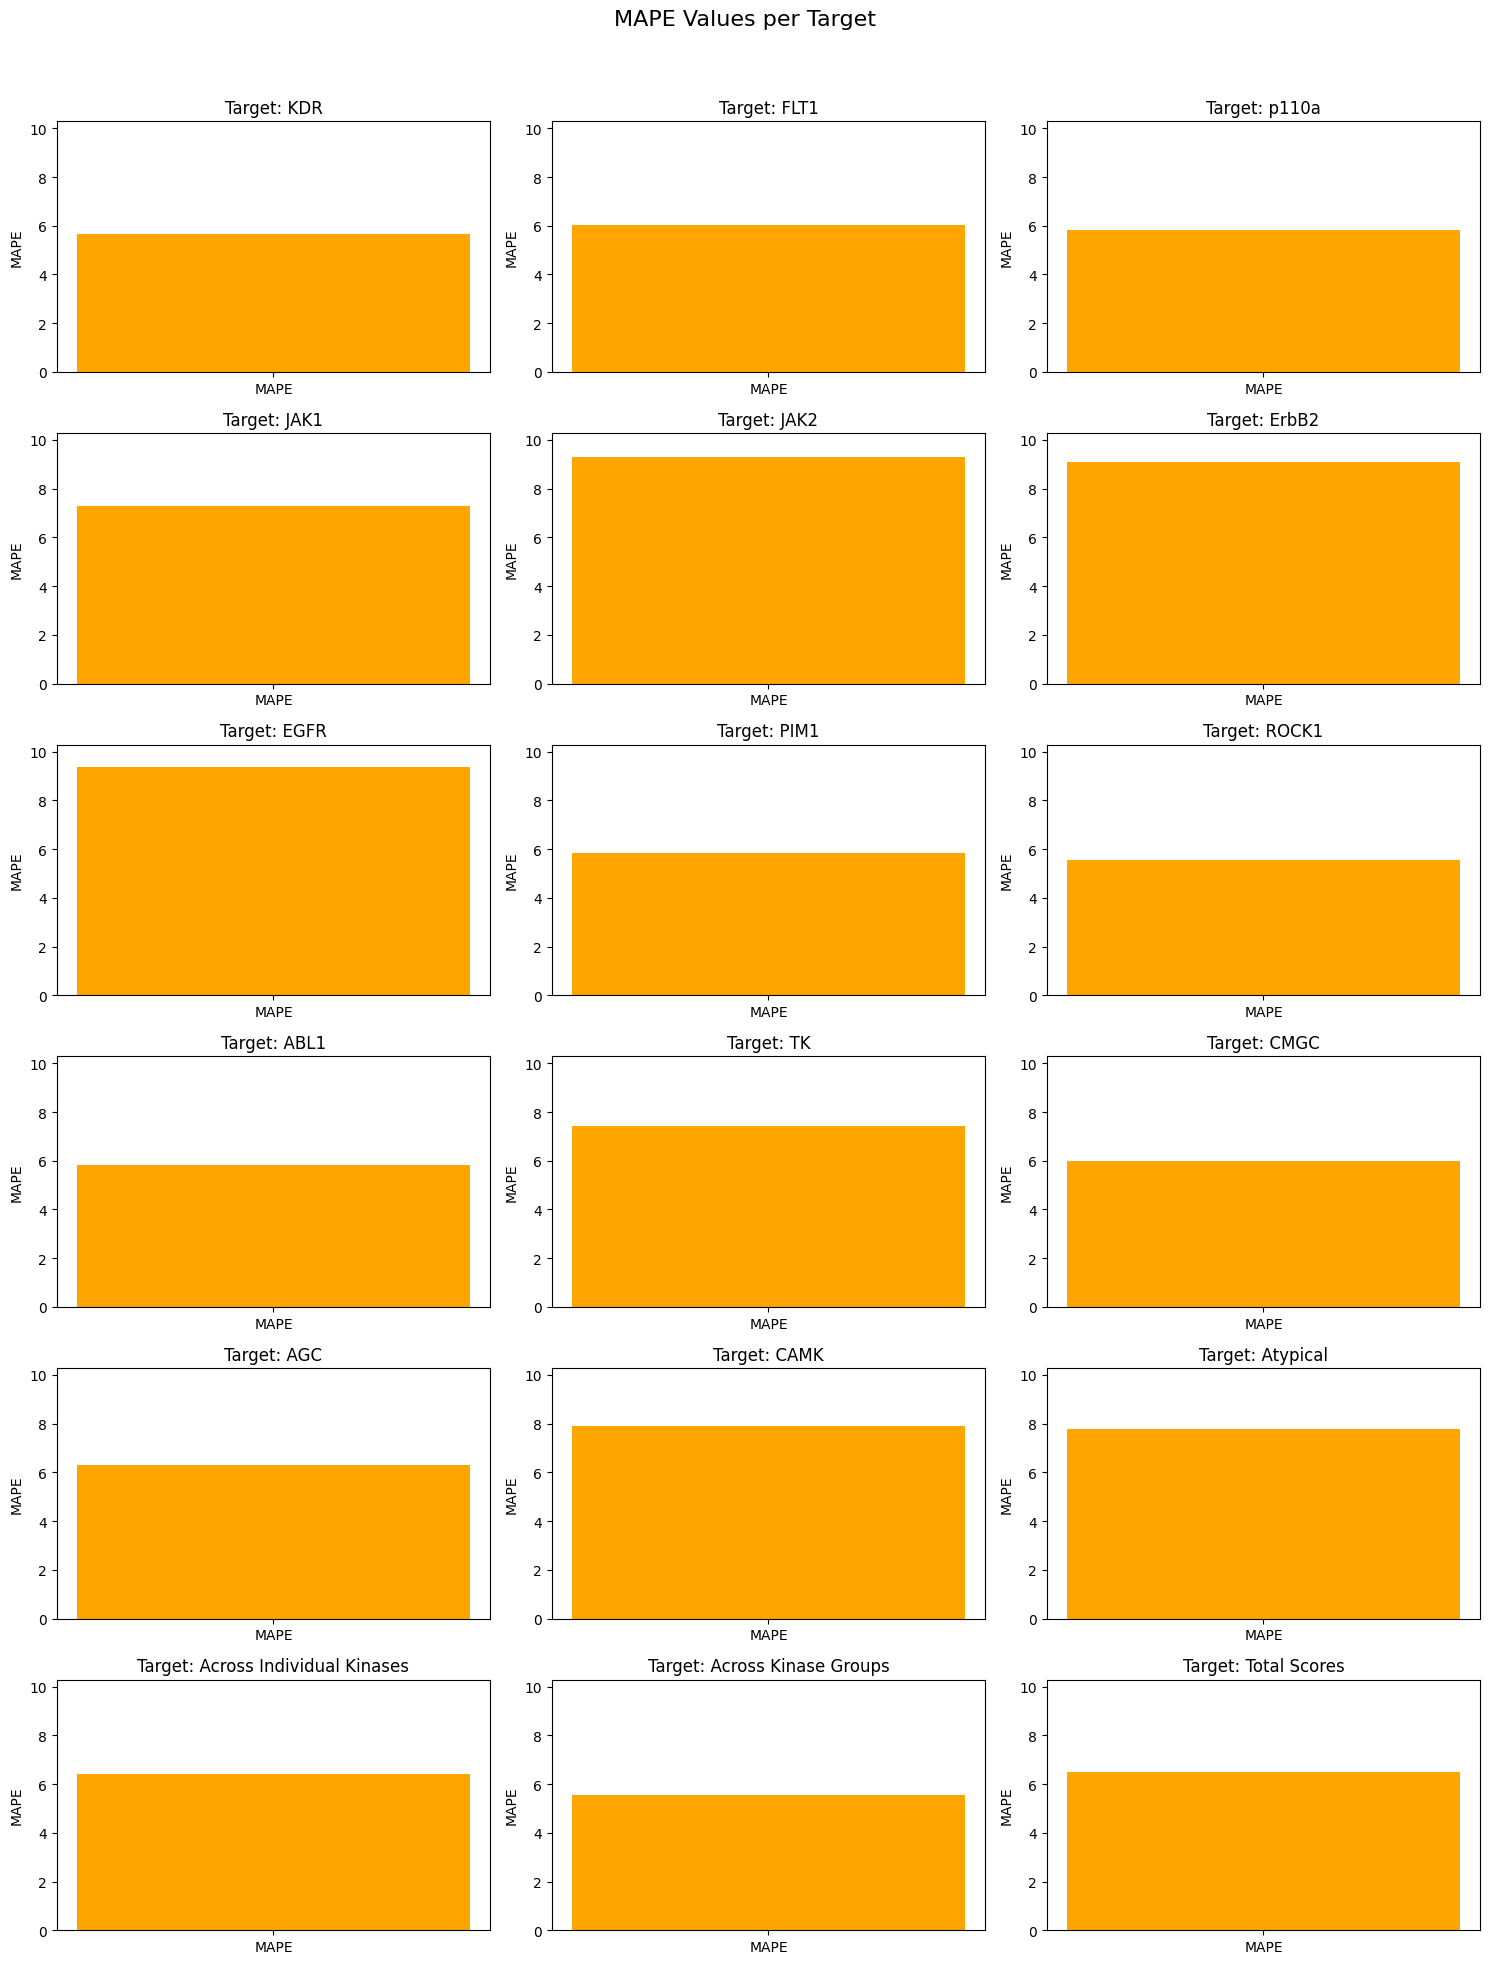

In [42]:

import matplotlib.pyplot as plt

mape_scores = [outputs[key][4] for key in outputs]
mape_scores.append(sum(mape_scores[0:9]) / 10)
mape_scores.append(sum(mape_scores[10:14]) / 5)
mape_scores.append(sum(mape_scores[0:14]) / 15)

kinase_names = [
    "KDR", "FLT1", "p110a", "JAK1", "JAK2", "ErbB2", "EGFR", "PIM1", "ROCK1", "ABL1",
    "TK", "CMGC", "AGC", "CAMK", "Atypical", "Across Individual Kinases", "Across Kinase Groups", "Total Scores"
]

fig, axes = plt.subplots(6, 3, figsize=(15, 20))
fig.suptitle('MAPE Values per Target', fontsize=16)
axes = axes.flatten()

for i in range(len(mape_scores)):
    ax = axes[i]
    ax.bar(['MAPE'], [mape_scores[i]], color=['orange'])
    ax.set_ylim(0, max(mape_scores) * 1.1)
    ax.set_title(f'Target: {kinase_names[i]}')
    ax.set_ylabel('MAPE')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('mape_values_reg.png')
plt.show()

In [41]:

y_trues = [
    y_test_reg_KDR,
    y_test_reg_FLT1,
    y_test_reg_p110a,
    y_test_reg_JAK1,
    y_test_reg_JAK2,
    y_test_reg_ErbB2,
    y_test_reg_EGFR,
    y_test_reg_PIM1,
    y_test_reg_ROCK1,
    y_test_reg_ABL1,
    y_test_reg_TK,
    y_test_reg_CMGC,
    y_test_reg_AGC,
    y_test_reg_CAMK,
    y_test_reg_Atypical,
]

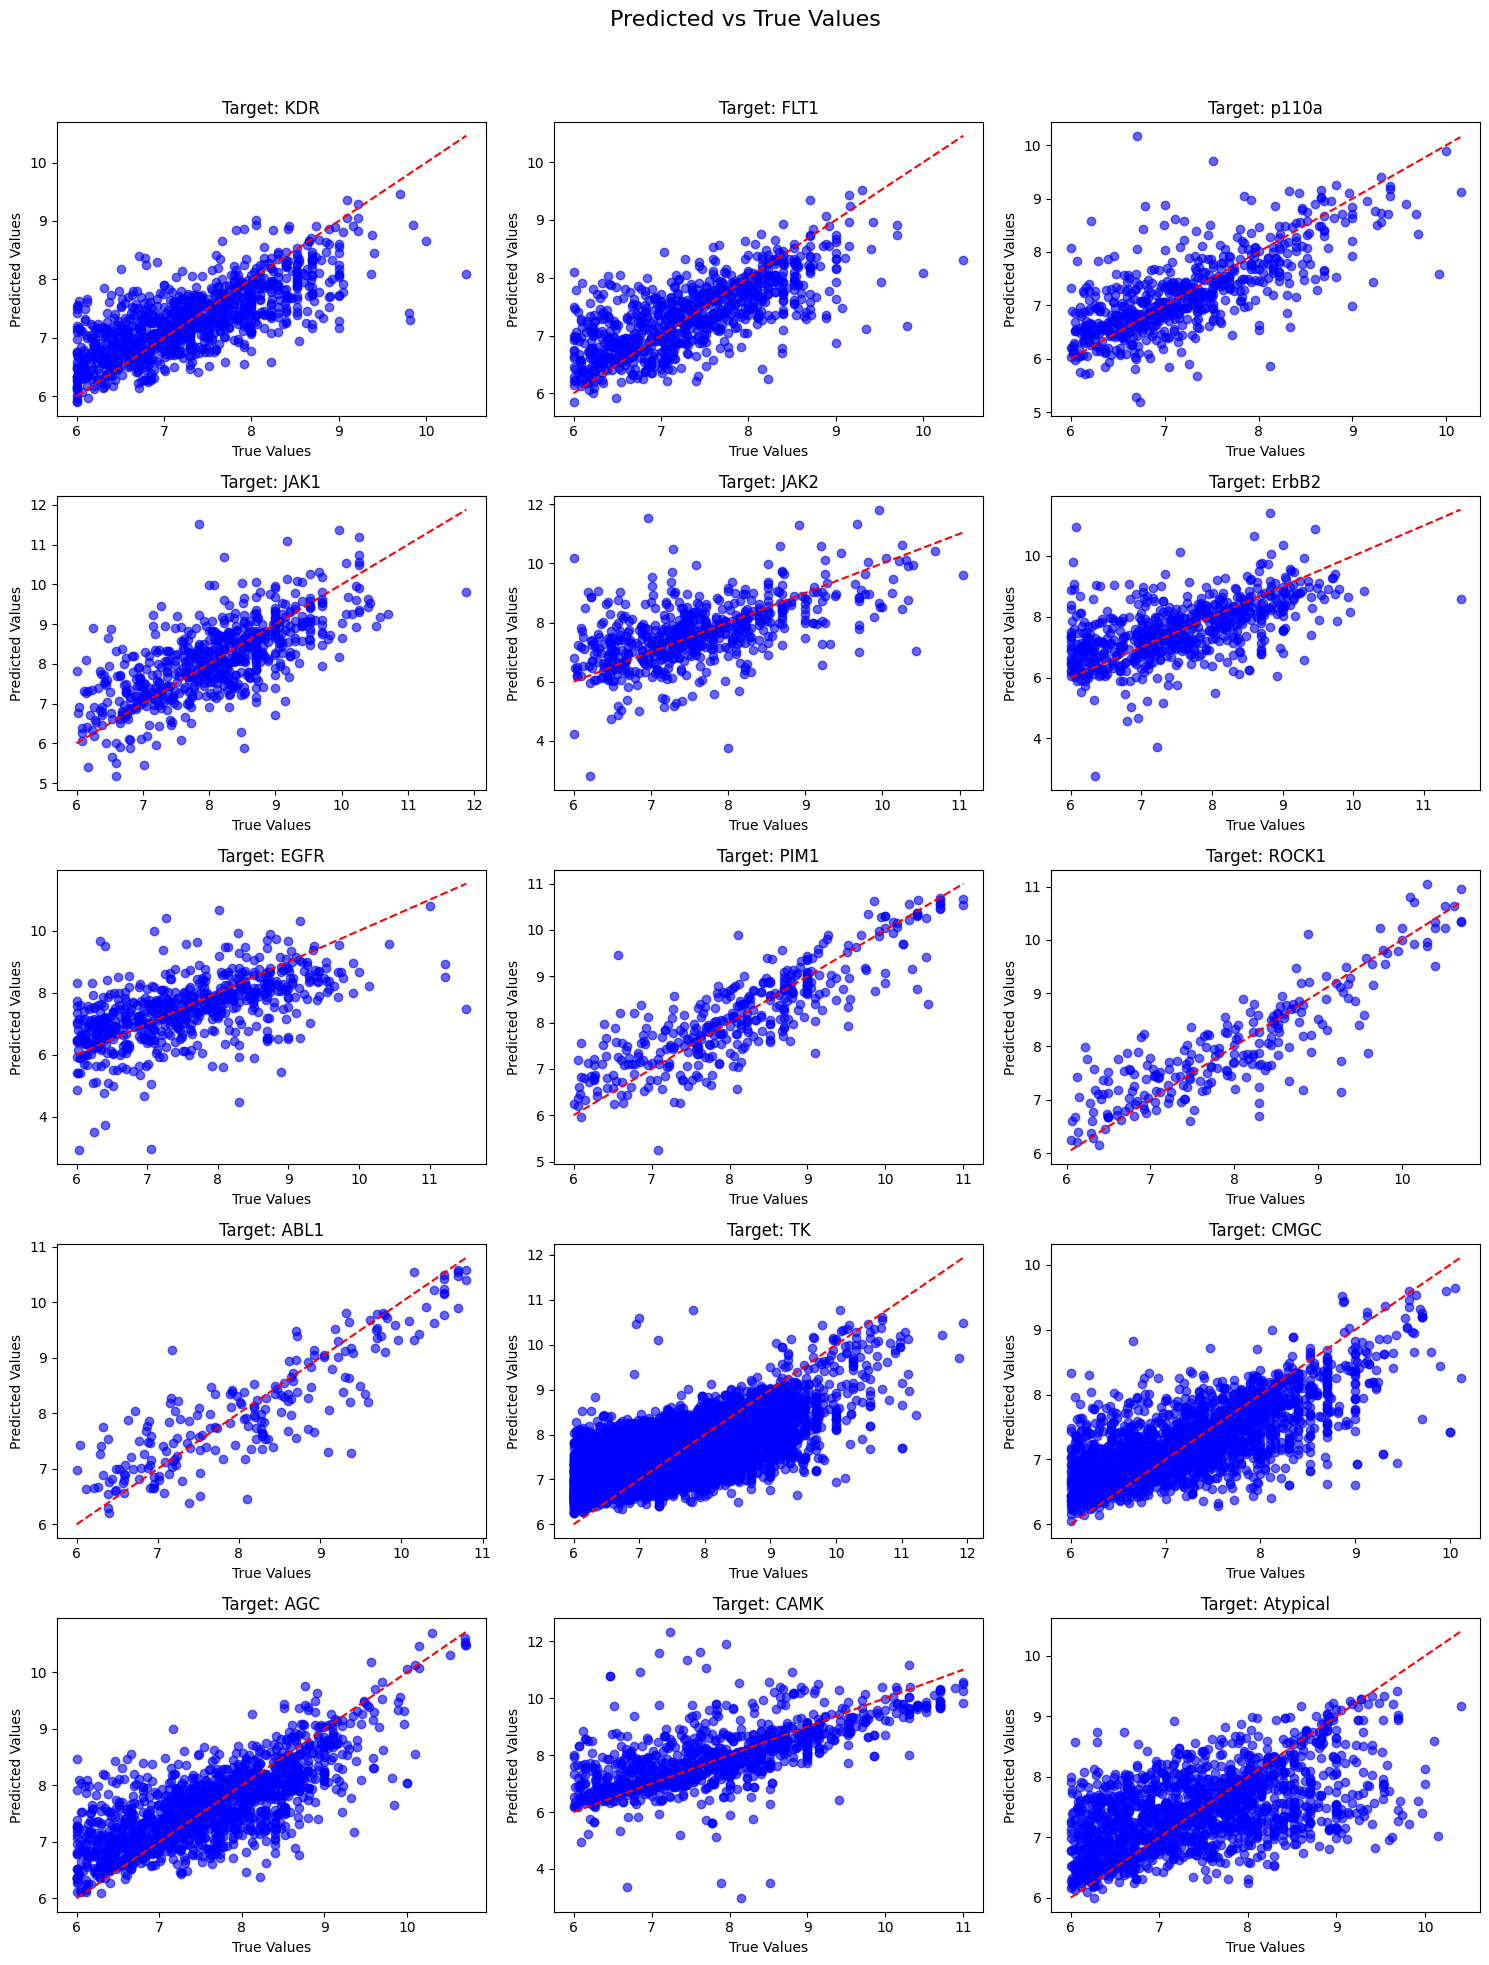

In [36]:
import matplotlib.pyplot as plt

num_models = len(outputs)
fig, axes = plt.subplots(5, 3, figsize=(15, 20))
fig.suptitle('Predicted vs True Values', fontsize=16)
axes = axes.flatten()

for i, (model_name, metrics) in enumerate(outputs.items()):
    ax = axes[i]
    preds = metrics[5]
    trues = y_trues[i]
    ax.scatter(trues, preds, alpha=0.6, color='blue')
    ax.plot([min(trues), max(trues)], [min(trues), max(trues)], 'r--')
    ax.set_title(f'Target: {kinase_names[i]}')
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predicted Values')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('predicted_vs_true_reg.png')
plt.show()


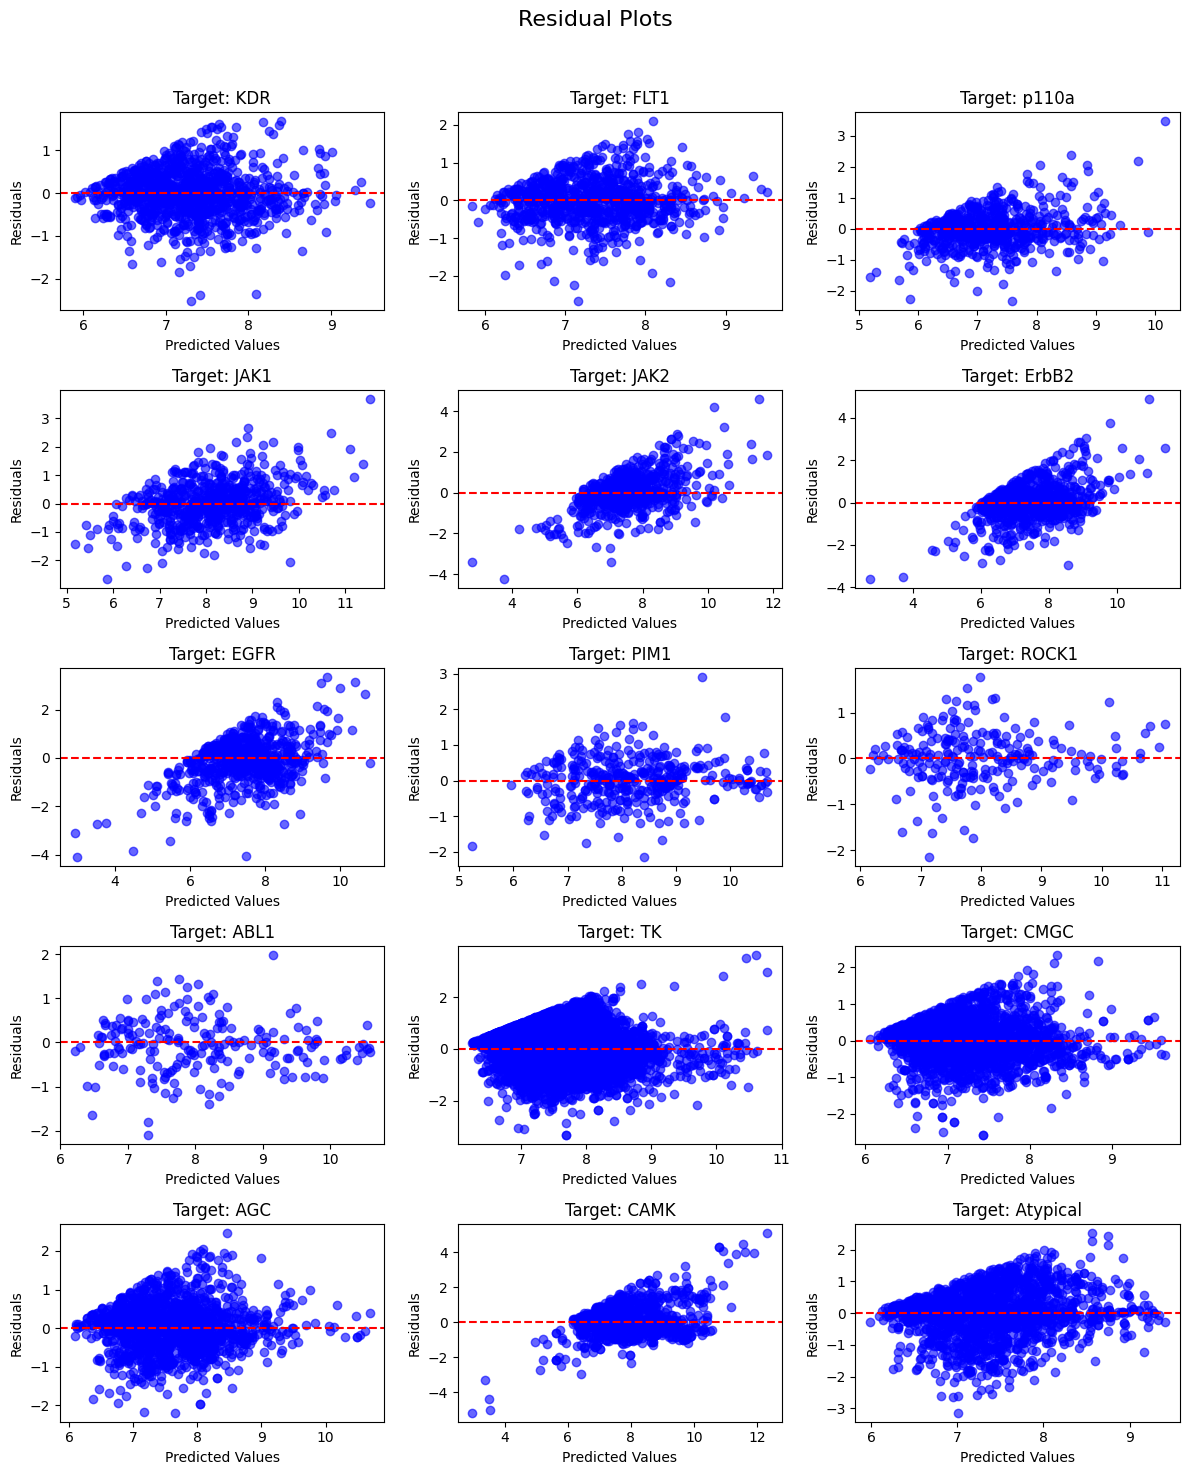

In [45]:

import matplotlib.pyplot as plt

rows, cols = 5, 3
subplot_width = 4
subplot_height = 3
fig_width = cols * subplot_width
fig_height = rows * subplot_height
fig, axes = plt.subplots(rows, cols, figsize=(fig_width, fig_height))
fig.suptitle('Residual Plots', fontsize=16)
axes = axes.flatten()

for i, (model_name, metrics) in enumerate(outputs.items()):
    ax = axes[i]
    preds = metrics[5]
    trues = y_trues[i]
    residuals = [p - t for p, t in zip(preds, trues)]
    ax.scatter(preds, residuals, alpha=0.6, color='blue')
    ax.axhline(0, color='red', linestyle='--')
    ax.set_title(f'Target: {kinase_names[i]}')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Residuals')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('residual_plots_reg.png')
plt.show()


In [48]:
# ROC_AUC_CURVE for Classification (I forgot to do this earlier)
import joblib
kinase_names = [
    "KDR",
    "FLT1",
    "p110a",
    "JAK1",
    "JAK2",
    "ErbB2",
    "EGFR",
    "PIM1",
    "ROCK1",
    "ABL1",
    "TK",
    "CMGC",
    "AGC",
    "CAMK",
    "Atypical"
]
classification_imports = [joblib.load(f"{i}_class.pkl") for i in kinase_names]

In [52]:
y_class_trues = [
    y_test_class_KDR,
    y_test_class_FLT1,
    y_test_class_p110a,
    y_test_class_JAK1,
    y_test_class_JAK2,
    y_test_class_ErbB2,
    y_test_class_EGFR,
    y_test_class_PIM1,
    y_test_class_ROCK1,
    y_test_class_ABL1,
    y_test_class_TK,
    y_test_class_CMGC,
    y_test_class_AGC,
    y_test_class_CAMK,
    y_test_class_Atypical,
]

X_class_trues = [
    X_test_KDR,
    X_test_FLT1,
    X_test_p110a,
    X_test_JAK1,
    X_test_JAK2,
    X_test_ErbB2,
    X_test_EGFR,
    X_test_PIM1,
    X_test_ROCK1,
    X_test_ABL1,
    X_test_TK,
    X_test_CMGC,
    X_test_AGC,
    X_test_CAMK,
    X_test_Atypical,
]

y_class_probas = [model.predict_proba(np.stack(X))[:, 1] for model, X in zip(classification_imports, X_class_trues)]

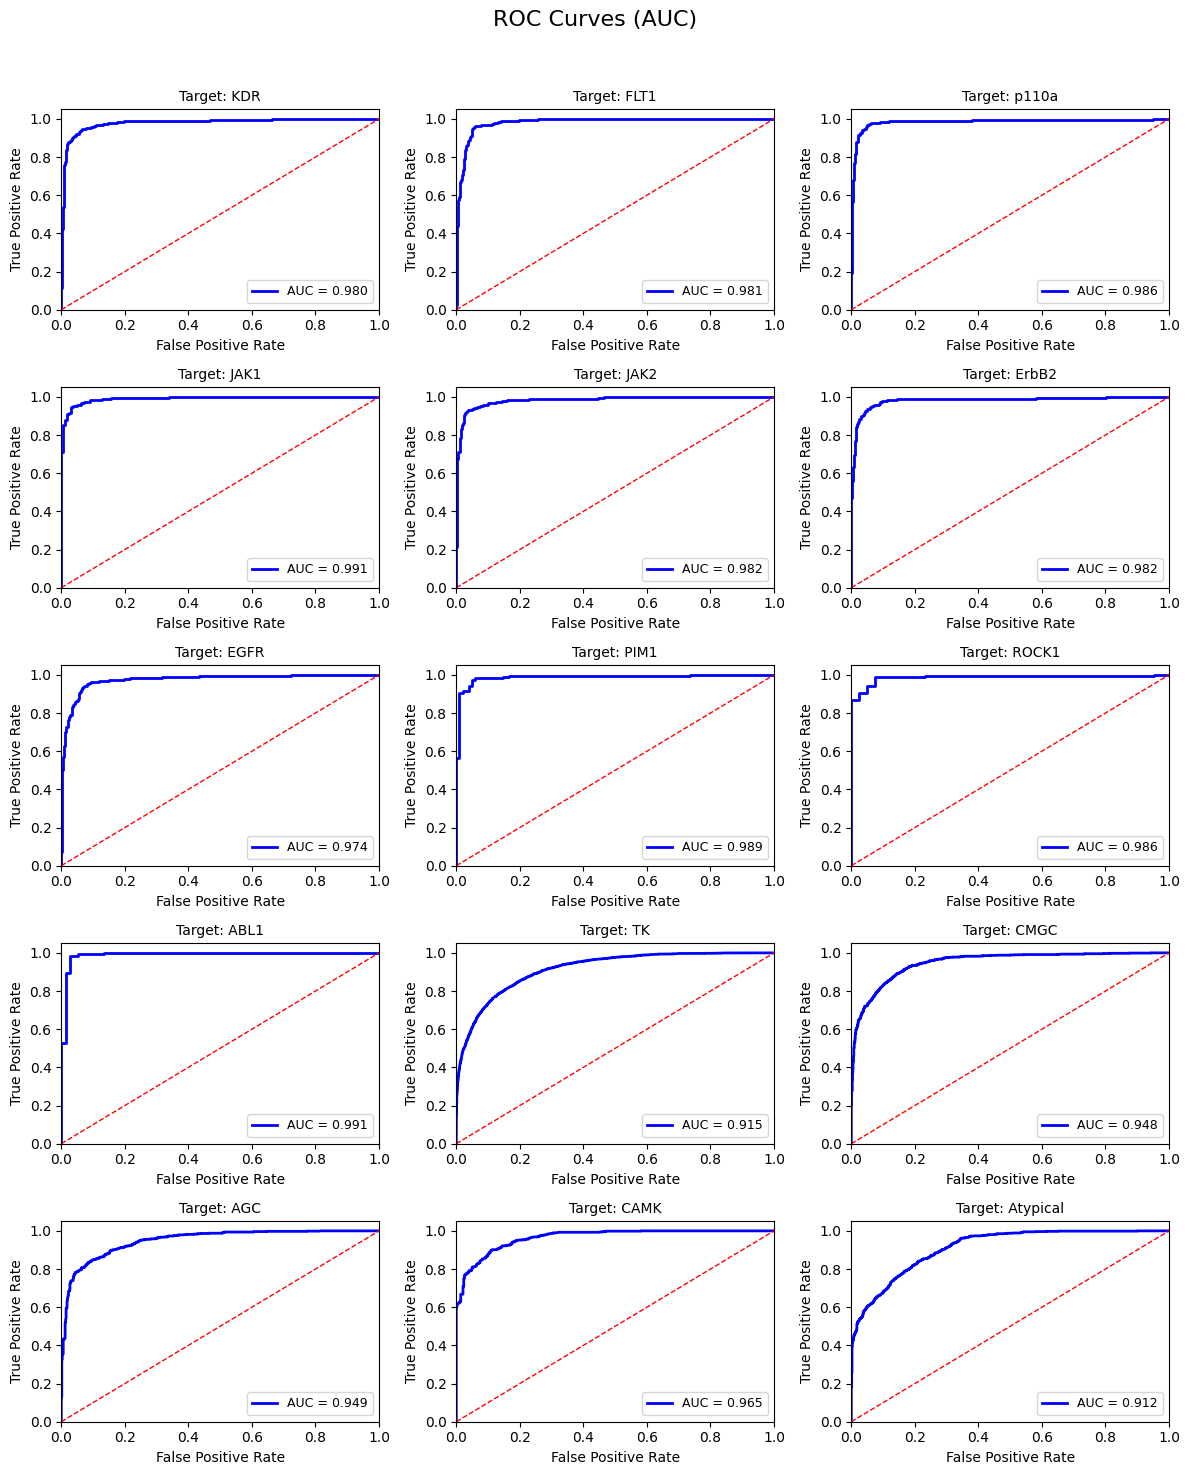

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

rows, cols = 5, 3
subplot_width = 4
subplot_height = 3
fig_width = cols * subplot_width
fig_height = rows * subplot_height
fig, axes = plt.subplots(rows, cols, figsize=(fig_width, fig_height))
fig.suptitle('ROC Curves (AUC)', fontsize=16)
axes = axes.flatten()

for i in range(15):
    ax = axes[i]
    y_true = y_class_trues[i]
    y_score = y_class_probas[i]
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.3f}')
    ax.plot([0, 1], [0, 1], color='red', linestyle='--', lw=1)
    ax.set_title(f'Target: {kinase_names[i]}', fontsize=10)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right', fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('roc_curves_class.png', dpi=300)
plt.show()